---
title: "Naive Bayes"
format:
  html:
      embed-resources: true
      code-fold: true
---

## Introduction to Naive Bayes

Naive Bayes classification is a group of supervised learning algorithms which use Bayes' theorem as their foundation. The "naive" aspect of these algorithms is the assumption that every pair of features are conditionally independent. [^1] This can be better understood via the Bayes' Theorem formula and how it applies in Naive Bayes. Given an output variable $y$ and several feature variables $x_i$, Bayes' Theorem posits the following:

$P\left(y | x_1, \ldots, x_n\right)=\frac{P(y) P\left(x_1, \ldots, x_n | y\right)}{P\left(x_1, \ldots, x_n\right)}$

The assumption that all feature variables are conditionally independent can be represented with the formula

$P\left(x_i \mid y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n\right)=P\left(x_i \mid y\right)$

which essentially states that the values of each $x_i$ depend solely on $y$, not the values from any other feature variable. Thus, we can substitute the products of all conditional probabilities into Bayes' Theorem to represent the relationship as

$P\left(y \mid x_1, \ldots, x_n\right)=\frac{P(y) \prod_{i=1}^n P\left(x_i \mid y\right)}{P\left(x_1, \ldots, x_n\right)}$.

Using this foundation, Naive Bayes classification algorithms attempt to establish classifiers for a dataset by considering values for each feature and assigning probabilities that it belongs in a certain class of the specified output variable. To do this, the algorithm will first take in data from a test dataset. When executing Naive Bayes classification, it is generally recommended to partition cleaned data such that 80% of it belongs in the test dataset. The algorithm will iterate over the feature variables and observe the output, ultimately creating a model for the extents to which the feature variables predict the output classifications.

Due to the foundation being on Bayes' Theorem, these methods are probabilistic in nature. That is, rather than being able to decisively classify new data, the algorithms work based on conditional probabilities that records belong to a particular class.

Discerning when to use the different variants of Naive Bayes classification is crucial for obtaining meaningful results. Firstly, Gaussian Naive Bayes (GNB) assumes that the feature variables follow a normal distribution. Thus, if we have data that we know comes from a normally distributed population, we can use the appropriate likelihood function for parameter estimation. The same applies for other methods of Naive Bayes classification. Other popular algorithms include Multinomial Naive Bayes, Bernoulli Naive Bayes, Categorical Naive Bayes, and others. Essentially, the presumed distribution of the feature variables can be leveraged to give an appropriate likelihood function, which aids in estimating parameters.

### Naive Bayes for this Project

For the purposes of our analysis, Naive Bayes can be used to analyze both record and text data. Firstly, the record data we will be using is the Census data which contains survey responses on various demographic features. The purpose of this will be to apply the Categorical Naive Bayes algorithm to features such as sex, race, and marital status to fit a model with a respondant's method of transportation to commute to work as the output variable. This will allow us to gain insights on which types of people are most affected by changes in public transit policy and service, providing valuable context for how a city's conditions can impact its residents.

Secondly, the labeled text data that we will use is the combined dataset of Yelp reviews for WMATA and BART. These revies contain textual responses with accompanying numerical ratings (1-5 stars). Thus, the text will be considered the feature set for Multinomial Naive Bayes, with the ratings deemed the output, as it labels the review with a scale of satisfaction or dissatisfaction with a service. The purpose of this is to analyze public sentiment regarding public transit systems and how that may affect usage or responses to potential policy changes.

## Preparing Data for Naive Bayes

### Preparing Record Data

To prepare this data, the first step is to filter out columns that will not be fit in the Categorical Naive Bayes algorithm.

In [70]:
from codecs import ignore_errors
import comm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import shutil

commute=pd.read_csv("../data/cleaned_data/commute_cleaned.csv")
commute = commute.drop(columns=['Unnamed: 0','age','income','city_population_00s','transportation_time'])
commute['transportation_type'].value_counts()

transportation_type
Private Vehicle    1088363
Work From Home      269004
Walk                 36364
Public Transit       33144
Other                16077
Bicycle               5869
Name: count, dtype: int64

As we can see from the distribution of our target variable, `transportation_type`, this data is very unbalanced. There are significantly more respondents who reported that their primary method of transportation for commuting to work is via `Private Vehicle` than any other, and the `Work From Home` group is also over-represented. In cases like this, it is common practice to over- or under-sample from certain groups to balance out the dataset. Without this practice, any supervised learning algorithm will generally predict the over-represented group to reduce the probability of inaccuracies. Therefore, we will under-sample from the two largest groups to bring them within 1,000 responses of the next-most represented group. This can be done via random sample to ensure the data isn't tampered with too much.

In [72]:
commute = commute.drop(commute[commute['transportation_type']=="Private Vehicle"].sample(n=1052000).index)
commute = commute.drop(commute[commute['transportation_type']=="Work From Home"].sample(n=233000).index)
commute['transportation_type'].value_counts()

transportation_type
Walk               36364
Private Vehicle    36363
Work From Home     36004
Public Transit     33144
Other              16077
Bicycle             5869
Name: count, dtype: int64

It is still important to note that this data is no longer representative of the total population, as the groups have been artificially imbalanced. For supervised learning, this is a better balance of the `transportation_type` variable, but we should keep in mind the altered distribution when making any conclusions.

The goal of Naive Bayes is to predictions on your test data using a model that was built using test data. Thus, separating our present data into training and testing datasets is crucial for proper execution. It is generally best practice to partition 80% of this into the test dataset, which is done by specifying `test_size` in the `train_test_split` function of `sklearn`.

Given our present data, in order to execute Categorical Naive Bayes, we must encode the categorical data with associated numbers. `sklearn`, a machine learning software tool in Python which will be used throughout this process, has functions `OrdinalEncoder` and `LabelEncoder` to accomplish this. Thus, that will be applied to both train and test datasets once partitioned.

*Note: Code for feature selection with categorical variables partially repurposed from: https://machinelearningmastery.com/feature-selection-with-categorical-data/*

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

dataset = commute.values
X = dataset[:, :-1]
y = dataset[:,-1]
X = X.astype(str)

def prepare_inputs(X_train, X_test):
     oe = OrdinalEncoder()
     oe.fit(X_train)
     X_train_enc = oe.transform(X_train)
     X_test_enc = oe.transform(X_test)
     return X_train_enc, X_test_enc

def prepare_targets(y_train, y_test):
     le = LabelEncoder()
     le.fit(y_train)
     y_train_enc = le.transform(y_train)
     y_test_enc = le.transform(y_test)
     return y_train_enc, y_test_enc
 
def select_features(X_train, y_train, X_test):
     fs = SelectKBest(score_func=chi2, k='all')
     fs.fit(X_train, y_train)
     X_train_fs = fs.transform(X_train)
     X_test_fs = fs.transform(X_test)
     return X_train_fs, X_test_fs, fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

### Preparing Text Data

To prepare this data, we must first combine WMATA and BART datasets of Yelp reviews. Since this is not an exercise in comparing and contrasting the two, it is necessary to leverage the scalability of Naive Bayes classification by consolidating this data. The next steps are to vectorize the text, randomly shuffle the records, and again split into training and test data sets, where 80% of the data belongs to the training set.

*Note: The code for text data classification is partially repurposed from DSAN-5000 Lab 3.2*

In [81]:
yelp=pd.read_csv("../data/cleaned_data/yelp_cleaned.csv")

In [82]:
reviews=[]
ratings=yelp['Rating']
for i in range(0,yelp.shape[0]):
    keep="abcdefghijklmnopqrstuvwxyz "
    replace=".,!;"
    tmp=""
    for char in yelp['Review'][i].replace("<br />","").lower():
        if char in replace:
            tmp+=" "
        if char in keep:
            tmp+=char
    tmp=" ".join(tmp.split())
    reviews.append(tmp)

ratings = np.array(ratings)


In [83]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorize(corpus,MAX_FEATURES):
    vectorizer=CountVectorizer(max_features=MAX_FEATURES,stop_words="english")   

    Xs  =  vectorizer.fit_transform(corpus)   
    X=np.array(Xs.todense())

    maxs=np.max(X,axis=0)
    return (np.ceil(X/maxs),vectorizer.vocabulary_)

(x,vocab0)=vectorize(reviews,MAX_FEATURES=10000)
vocab1 = dict([(value, key) for key, value in vocab0.items()])
df2=pd.DataFrame(x)
s = df2.sum(axis=0)
df2=df2[s.sort_values(ascending=False).index[:]]
#print(df2.head())
i1=0
vocab2={}
for i2 in list(df2.columns):
    vocab2[i1]=vocab1[int(i2)]
    i1+=1
df2.columns = range(df2.columns.size)
x=df2.to_numpy()



In [84]:
import random
N=x.shape[0]
l = [*range(N)]
cut = int(0.8 * N)
random.shuffle(l)
train_index = l[:cut]
test_index = l[cut:]

print(train_index[0:10])
print(test_index[0:10])

[427, 660, 1495, 1509, 1076, 1876, 730, 738, 146, 684]
[393, 525, 2400, 1428, 399, 53, 2188, 1916, 2364, 456]


## Feature Selection 

### Feature Selection for Record Data

The following code and output provides the feature selection process for our record data.

sex: 413.7170268487656
marital_status: 1073.8327696873725
race: 8301.788540304213
hispanic: 139.35812553260118
employment: nan


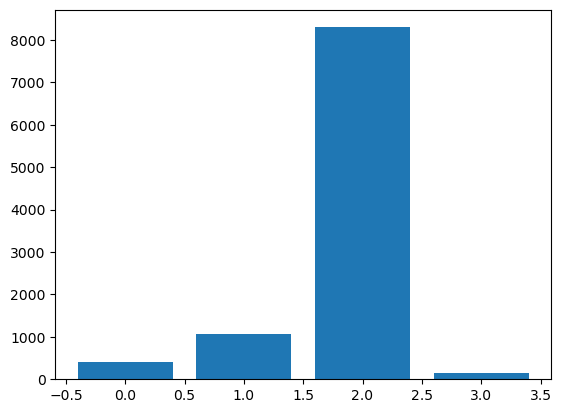

In [74]:
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
for i in range(len(fs.scores_)):
     print(str(commute.columns[i]) + ": " + str(fs.scores_[i]))
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

### Feature Selection for Text Data

The following code and output provides the feature selection process for our text data.

In [85]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import time

def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    acc_train= accuracy_score(y_train, yp_train)*100
    acc_test= accuracy_score(y_test, yp_test)*100

    if(i_print):
        print(acc_train,acc_test,time_train,time_eval)

    return (acc_train,acc_test,time_train,time_eval)


#TEST
print(type(x),type(ratings))
print(x.shape,ratings.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,ratings,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2435, 10000) (2435,)
(2435, 10000) (2435,)
87.83367556468173 56.05749486652978 0.1518350000000055 0.15289999999998827


In [86]:
def initialize_arrays():
    global num_features,train_accuracies
    global test_accuracies,train_time,eval_time
    num_features=[]
    train_accuracies=[]
    test_accuracies=[]
    train_time=[]
    eval_time=[]

initialize_arrays()

# DEFINE SEARCH FUNCTION
def partial_grid_search(num_runs, min_index, max_index):
    for i in range(1, num_runs+1):
        # SUBSET FEATURES 
        upper_index=min_index+i*int((max_index-min_index)/num_runs)
        xtmp=x[:,0:upper_index]

        #TRAIN 
        (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,ratings,i_print=False)

        if(i%5==0):
            print(i,upper_index,xtmp.shape[1],acc_train,acc_test)
            
        #RECORD 
        num_features.append(xtmp.shape[1])
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_time.append(time_train)
        eval_time.append(time_eval)

# DENSE SEARCH (SMALL NUMBER OF FEATURES (FAST))
partial_grid_search(num_runs=100, min_index=0, max_index=1000)

# SPARSE SEARCH (LARGE NUMBER OF FEATURES (SLOWER))
partial_grid_search(num_runs=20, min_index=1000, max_index=10000)

5 50 50 44.866529774127315 43.121149897330596
10 100 100 51.74537987679672 49.28131416837782
15 150 150 55.28747433264887 48.870636550308014
20 200 200 57.13552361396304 49.48665297741273
25 250 250 58.983572895277206 50.92402464065708
30 300 300 61.601642710472284 50.308008213552355
35 350 350 63.29568788501027 50.308008213552355
40 400 400 63.80903490759754 51.54004106776181
45 450 450 64.27104722792608 49.89733059548255
50 500 500 66.4271047227926 51.74537987679672
55 550 550 67.71047227926078 51.74537987679672
60 600 600 68.63449691991786 51.129363449691986
65 650 650 68.99383983572895 50.308008213552355
70 700 700 69.04517453798768 51.33470225872689
75 750 750 70.99589322381931 51.74537987679672
80 800 800 72.07392197125256 50.71868583162218
85 850 850 73.1006160164271 51.54004106776181
90 900 900 74.33264887063655 51.95071868583162
95 950 950 75.05133470225873 51.54004106776181
100 1000 1000 75.71868583162218 50.92402464065708
5 3250 3250 88.44969199178645 54.62012320328542
10 55

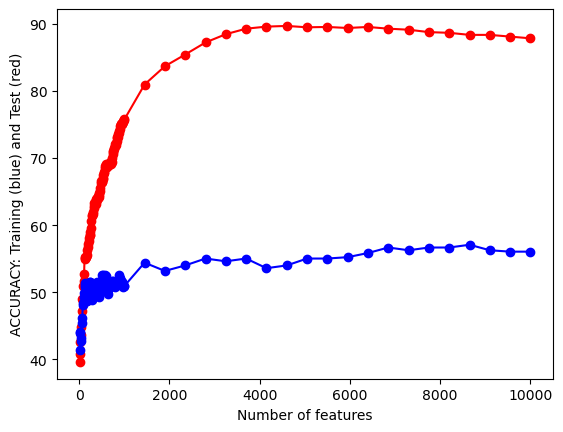

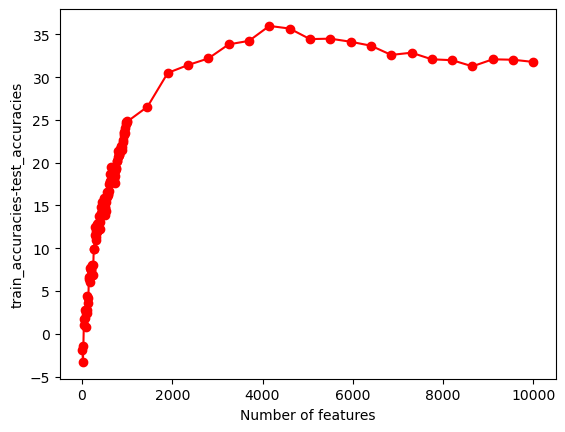

In [87]:
def save_results(path_root):
    out=np.transpose(np.array([num_features,train_accuracies,test_accuracies,train_time,eval_time])) 
    out=pd.DataFrame(out)
    out.to_csv(path_root+".csv")

def plot_results(path_root):
    plt.plot(num_features,train_accuracies,'-or')
    plt.plot(num_features,test_accuracies,'-ob')
    plt.xlabel('Number of features')
    plt.ylabel('ACCURACY: Training (blue) and Test (red)')
    plt.savefig(path_root+'-1.png')
    plt.show()

    plt.plot(num_features,np.array(train_accuracies)-np.array(test_accuracies),'-or')
    plt.xlabel('Number of features')
    plt.ylabel('train_accuracies-test_accuracies')
    plt.savefig(path_root+'-4.png')
    plt.show()

save_results('../data/naive_bayes'+"/partial_grid_search")
plot_results('../data/naive_bayes'+"/partial_grid_search")

In [88]:
x_var=np.var(x,axis=0)
from sklearn.feature_selection import VarianceThreshold

# DEFINE GRID OF THRESHOLDS 
num_thresholds=30
thresholds=np.linspace(np.min(x_var),np.max(x_var),num_thresholds)

#DOESN"T WORK WELL WITH EDGE VALUES 
thresholds=thresholds[1:-2]; #print(thresholds)

# INITIALIZE ARRAYS
initialize_arrays()

# SEARCH FOR OPTIMAL THRESHOLD
for THRESHOLD in thresholds:
    feature_selector = VarianceThreshold(threshold=THRESHOLD)
    xtmp=feature_selector.fit_transform(x)
    print("THRESHOLD =",THRESHOLD, xtmp.shape[1])

    (acc_train,acc_test,time_train,time_eval)=train_MNB_model(xtmp,ratings,i_print=False)
             
    #RECORD 
    num_features.append(xtmp.shape[1])
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    train_time.append(time_train)
    eval_time.append(time_eval)

THRESHOLD = 0.008536336885337658 1167
THRESHOLD = 0.016662164808711497 621
THRESHOLD = 0.02478799273208534 421
THRESHOLD = 0.032913820655459176 301
THRESHOLD = 0.041039648578833014 225
THRESHOLD = 0.04916547650220686 178
THRESHOLD = 0.0572913044255807 143
THRESHOLD = 0.06541713234895453 110
THRESHOLD = 0.07354296027232837 91
THRESHOLD = 0.08166878819570221 76
THRESHOLD = 0.08979461611907605 60
THRESHOLD = 0.0979204440424499 53
THRESHOLD = 0.10604627196582374 41
THRESHOLD = 0.11417209988919758 40
THRESHOLD = 0.12229792781257141 33
THRESHOLD = 0.13042375573594525 29
THRESHOLD = 0.1385495836593191 25
THRESHOLD = 0.14667541158269293 21
THRESHOLD = 0.15480123950606678 16
THRESHOLD = 0.1629270674294406 13
THRESHOLD = 0.17105289535281445 10
THRESHOLD = 0.17917872327618828 8
THRESHOLD = 0.18730455119956213 8
THRESHOLD = 0.19543037912293598 8
THRESHOLD = 0.2035562070463098 8
THRESHOLD = 0.21168203496968366 5
THRESHOLD = 0.21980786289305748 4


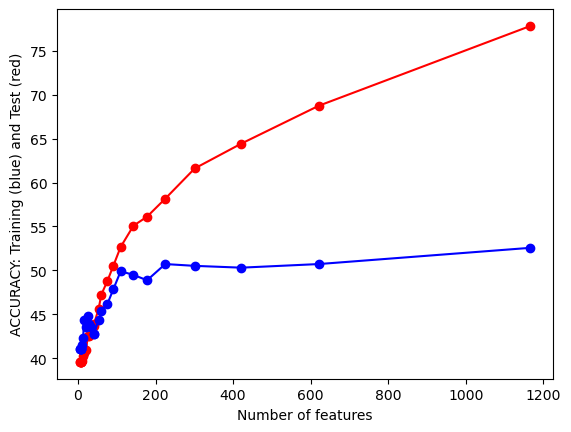

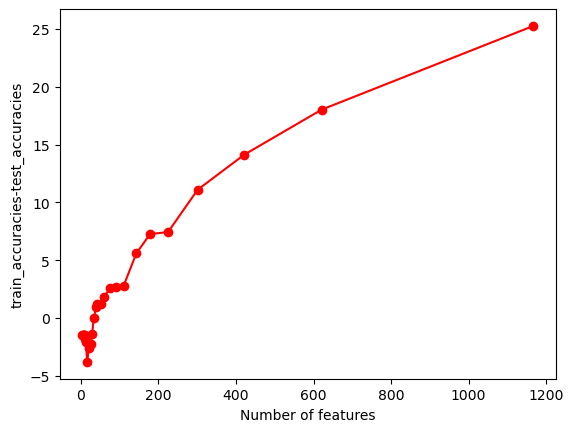

In [89]:
save_results("../data/naive_bayes"+"/variance_threshold")
plot_results("../data/naive_bayes"+"/variance_threshold")

## Naive Bayes

### Naive Bayes with Labeled Record Data

The following code, output, and comments show the process for Naive Bayes classification on record data.

In [75]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
import scipy
from scipy import stats
clf = CategoricalNB(force_alpha=True)
enc = OrdinalEncoder()
import warnings
warnings.simplefilter('ignore', np.RankWarning)
warnings.simplefilter('ignore', np.ComplexWarning)
warnings.filterwarnings('ignore', "Intel MKL ERROR")

feature_cols = feature_cols = [c for c in commute.columns if c != 'transportation_type']
X_train_df = pd.DataFrame(X_train_enc, columns=feature_cols)
X_test_df = pd.DataFrame(X_test_enc, columns=feature_cols)
included_vars = ['sex','race','marital_status']
included_vars_df = X_train_df[included_vars].copy()
sex_marital_corr = stats.spearmanr(included_vars_df['sex'], included_vars_df['marital_status']).statistic
print(sex_marital_corr)
sex_race_corr = stats.spearmanr(included_vars_df['sex'], included_vars_df['race']).statistic
print(sex_race_corr)
race_marital_corr = stats.spearmanr(included_vars_df['race'], included_vars_df['marital_status']).statistic
print(race_marital_corr)
sex_commute_corr = stats.spearmanr(included_vars_df['sex'], y_train).statistic
print(sex_commute_corr)
race_commute_corr = stats.spearmanr(included_vars_df['race'], y_train).statistic
print(race_commute_corr)
marital_commute_corr = stats.spearmanr(included_vars_df['marital_status'], y_train).statistic
print(marital_commute_corr)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-0.005800683251658714
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.043882164650110994
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
-0.11339339247229406
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require I

In [76]:
k = 3
mean_xx_corr = np.mean([sex_marital_corr,sex_race_corr,race_marital_corr])
mean_xy_corr = np.mean([sex_commute_corr,race_commute_corr,marital_commute_corr])
print(f"Number of features: {k}")
merit_score_numer = k * np.absolute(mean_xy_corr)
merit_score_denom = np.sqrt(k + k * (k + 1) * np.absolute(mean_xx_corr))
merit_score_s2 = merit_score_numer / merit_score_denom
print(f"Merit score: {merit_score_s2}")

Number of features: 3
Merit score: 0.006703356130666423


In [77]:
enc.fit(X_train)
X_train_enc = enc.transform(X_train)
clf.fit(X_train_enc, y_train)

CategoricalNB(force_alpha=True)

In [78]:
from sklearn.metrics import f1_score
enc.fit(X_test)
X_test_enc = enc.transform(X_test)
test_predictions = clf.predict(X_test_enc)
f1_score(y_true = y_test, y_pred = test_predictions, average='weighted')

0.2893517844889823

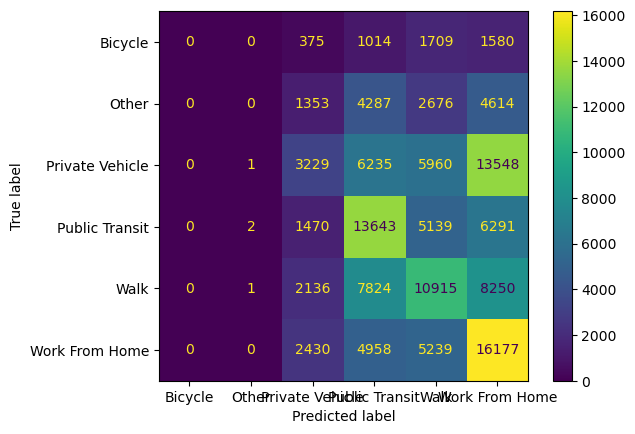

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, clf.predict(X_train_enc), labels=clf.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmd.plot()
plt.show()

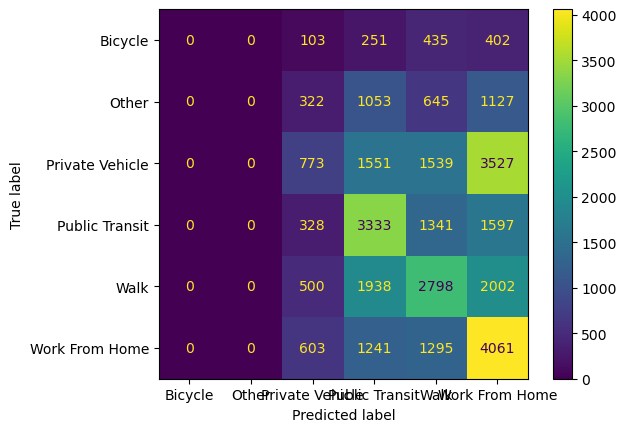

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, clf.predict(X_test_enc), labels=clf.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
cmd.plot()
plt.show()

Based on the F-score and these confusion matrices, it appears that this method was only somewhat effective at predicting the labels. An F-score of 0.29 is not very high, but for both the training and testing datasets, the most prevalent value in each column is the one on the diagonal. There were a significant amount of respondents who reported Private Vehicle as their primary method of transportation for which the model predicted that they would work from home. This indicates a potential similarity between these two groups. Overall, this was better than if the predictions were just randomly selected, but it is apparent that this is not an exhaustive predictor of the true label.

### Class Distribution

The record data we will be using comes from the IPUMS dataset containing results from the US Census Bureau. Our target variable will be `commute_method`, which each respondents answer to what their primary mode of transportation is for work. As this data has been cleaned, this categorical variable is portrayed via text with the following classes, with their respective totals:

- Private Vehicle - 47254 answers
- Public Transit - 3365
- Bicycle - 593
- Walked - 2322
- Worked from Home - 19013
- Other - 1156

The following is a visualization of the class distribution:

### Naive Bayes with Labeled Text Data

The following code, output, and comments show the process for Naive Bayes classification on record data.

In [90]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB

# CONVERT DF TO LIST OF STRINGS 
corpus=yelp["Review"].to_list()
y2=yelp["Rating"].to_numpy()

print("number of text chunks = ",len(corpus))
print(corpus[0:3])


number of text chunks =  2435
["What do I know, I'm just a stupid tourist who comes into the city once a year and takes 3-4 subway rides each time.A lot cleaner than some of our Philly train stations, that's for sure. Pretty easy to figure out how to get from place to place with Google maps.Love the contactless method - tap and go.", 'This Company is A Literally A Gangsters Mafia , an Organized Group of Criminals with uniforms !!! and I\'ll explain exactly why I say that . (1) they are stilling people\'s money , by damaging their metro cards on purpose !!! In the Busses and subway train station machines !! All that is happening from one reason only that people would buy another card , and another one , and if you send your damaged card to them ? they taking the card and say goodbye to your card and to your money !!! For example in the last six months , I buy in the beginning of the month , a monthly unlimited metro card , pay 127$ !!! And already twelve times I purchased the same card 

In [91]:
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
text_Xs  =  vectorizer.fit_transform(corpus)   
text_X=np.array(text_Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(text_X,axis=0)
text_X=np.ceil(text_X/maxs)

# DOUBLE CHECK 
print(text_X.shape,y2.shape)
print("DATA POINT-0:",text_X[0,0:10],"  y2 =",y2[0])

(2435, 5804) (2435,)
DATA POINT-0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]   y2 = 4


In [93]:
from sklearn.model_selection import train_test_split

test_ratio=0.2

# SPLIT ARRAYS OR MATRICES INTO RANDOM TRAIN AND TEST SUBSETS.
text_x_train, text_x_test, text_y_train, text_y_test = train_test_split(text_X, y2, test_size=test_ratio, random_state=0)
text_y_train=text_y_train.flatten()
text_y_test=text_y_test.flatten()

print("x_train.shape		:",text_x_train.shape)
print("y_train.shape		:",text_y_train.shape)

print("X_test.shape		:",text_x_test.shape)
print("y_test.shape		:",text_y_test.shape)
print(text_y_train[0:100])

x_train.shape		: (1948, 5804)
y_train.shape		: (1948,)
X_test.shape		: (487, 5804)
y_test.shape		: (487,)
[1 3 4 3 2 1 2 1 4 1 1 5 1 4 2 1 1 2 3 2 4 1 1 1 2 4 1 1 5 4 2 1 1 1 5 1 2
 2 1 4 5 1 2 1 4 1 1 1 1 2 1 4 5 1 3 1 1 1 4 3 1 4 3 3 3 1 3 4 1 1 3 1 3 3
 1 5 1 4 4 1 5 3 1 3 3 1 5 3 1 2 1 5 2 4 1 1 4 2 5 3]


In [94]:
from sklearn import model_selection

def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary(model):
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      text_yp_train = model.predict(text_x_train)
      text_yp_test = model.predict(text_x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(text_y_train,text_yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(text_y_test,text_yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(text_y_train[0:20])
      print(text_yp_train[0:20])
      print("ERRORS:",text_yp_train[0:20]-text_y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(text_y_test[0:20])
      print(text_yp_test[0:20])
      print("ERRORS:",text_yp_test[0:20]-text_y_test[0:20])

In [95]:
model = MultinomialNB()
model.fit(text_x_train,text_y_train)
print_model_summary(model)

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 89.11704312114989
Number of mislabeled points out of a total 1948 points = 212

TEST SET (UNTRAINED DATA):
Accuracy: 52.361396303901444
Number of mislabeled points out of a total 487 points = 232

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 3 4 3 2 1 2 1 4 1 1 5 1 4 2 1 1 2 3 2]
[1 3 4 4 2 1 4 1 4 1 1 5 1 4 1 1 1 4 3 1]
ERRORS: [ 0  0  0  1  0  0  2  0  0  0  0  0  0  0 -1  0  0  2  0 -1]

TEST SET (UNTRAINED DATA):
[5 1 1 2 1 2 3 2 4 1 5 4 1 5 5 1 1 2 3 4]
[4 1 1 3 1 4 4 1 4 1 4 4 1 4 4 1 1 1 3 1]
ERRORS: [-1  0  0  1  0  2  1 -1  0  0 -1  0  0 -1 -1  0  0 -1  0 -3]


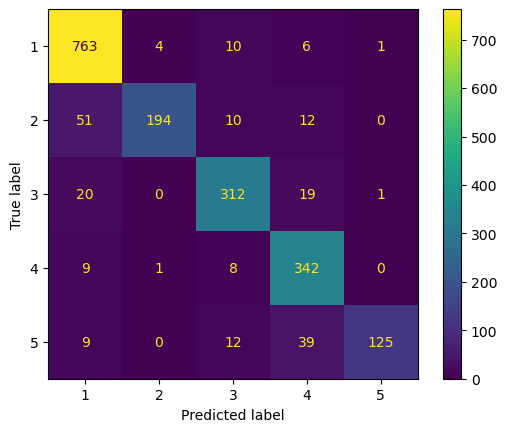

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(text_y_train, model.predict(text_x_train), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

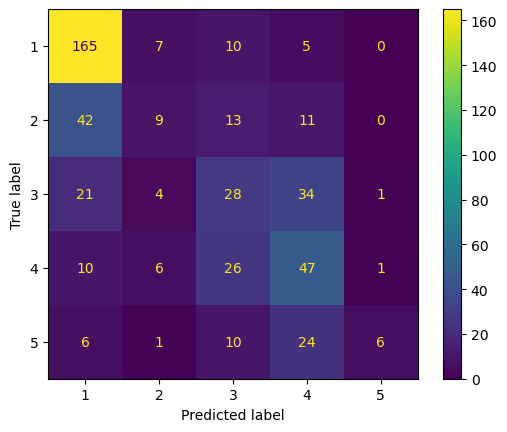

In [97]:
cm = confusion_matrix(text_y_test, model.predict(text_x_test), labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

These confusion matrices and accuracy scores show that the Naive Bayes method was very effective on the training dataset, and significantly less effective for the test set. An accuracy score of almost 90 is worth paying attention to, and the confusion matrix backs that up with large values on the diagonal. However, for the test data, this accuracy score dropped to just over 50. It is reasonable to conclude that this algorithm has its shortcomings when attempting to predict new data. Much of that is likely due to a lack of an established pattern within the data. In other words, the relationship between ratings and their respective text review is not consistent from one sample to another. Nonetheless, we can see from the final confusion matrix that the largest prediction value for each true value is on the diagonal for all labels, which does indicate that this is better than random chance.

## Conclusions

While there are clear shortcomings with the Naive Bayes methodology for both our record and text data, the ability to make predictions based on similarities within the feature variables is clearly there. Our predictions were more likely than not to match up with actual values.

This result tells us that there is value in looking at demographic data for predicting method of transportation for commuting to work. Thus, there are certain groups of people who are more affected by public transit efficiency and ubiquity than others. In terms of social value, that is an important distinction to make.

[^1]: “1.9. naive Bayes,” scikit, https://scikit-learn.org/stable/modules/naive_bayes.html (accessed Nov. 2, 2023). 